# Outline
The notebook is intended to demonstrate low-level implementation of image in-painting problem without utilizing Deep Learning libraries with JAX.

# Libraries

In [ ]:
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
from tqdm.notebook import tqdm

import scipy
from scipy import linalg

from pathlib import Path
from google.colab import drive

from IPython.display import Markdown, display

drive.mount('/content/drive')

SEED = 4212
onp.random.seed(SEED)

def printmd(s):
  display(Markdown(s))

Mounted at /content/drive


In [ ]:
source = Path.cwd() / 'drive' / 'MyDrive' 
p = source.glob('*')
files = [x for x in p if x.is_file()]
files

Image inpainting

Loaded the image `img_bad.png` and attempt to restore through inpainting

Image size: (342, 512)


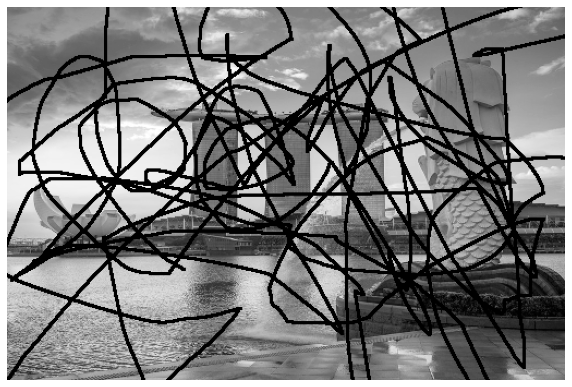

In [ ]:
#load image
path_img = source / 'img_bad.png'

im = onp.array(imageio.imread(path_img).astype(float)) / 255.
print(f"Image size: {im.shape}")

plt.figure(figsize=(10,10))
plt.imshow(im, cmap="gray")
plt.axis("off")
plt.show()

## Optimization Problem Framing

We have an image with damaged lines, $X \in \mathbb{R}^{342, 512}$. Taking the black lines with intensity 0 as missing values, we wish to restore the original image. 

Our approach will be to find $Z^*$ to reconstruct $X$ using low-rank approximation and with regularization.

\begin{align}
Z^* &= \underset{Z}{\mathrm{argmin}} 
    \sum_{\mathrm{Observed(i,j)}}
        (X_{i,j} - Z_{i,j})^2  \\
\end{align}

We impute missing $X_{i,j}$ with $Z_{i,j}$. We want to find a rank $r > 1$ such that $Z = UV$, where $U \in \mathbb{R}^{p, r}, \ V \in \mathbb{R}^{r, q}$.





In [ ]:
rank_values = [5, 15, 50, 100, 150, 300]
images = []

def perform_svd(a,rank):
    u, s, v = linalg.svd(a)
    ur = u[:, :rank]
    sr = onp.matrix(linalg.diagsvd(s[:rank], rank,rank))
    vr = v[:rank, :]
    return onp.asarray(ur*sr*vr)


for rank in rank_values:
    img = perform_svd(im, rank)
    images.append(img)  

## Choosing r

To pick an appropriate value of $r$, we run Singular-Value Decomposition on the original $X$ matrix for different values of $r$. We notice the drop in image quality between $r$ 100 vs $r$ 150 is marginal and hence feel that $100$ is a suitable value for $r$ that approximates the original image well.

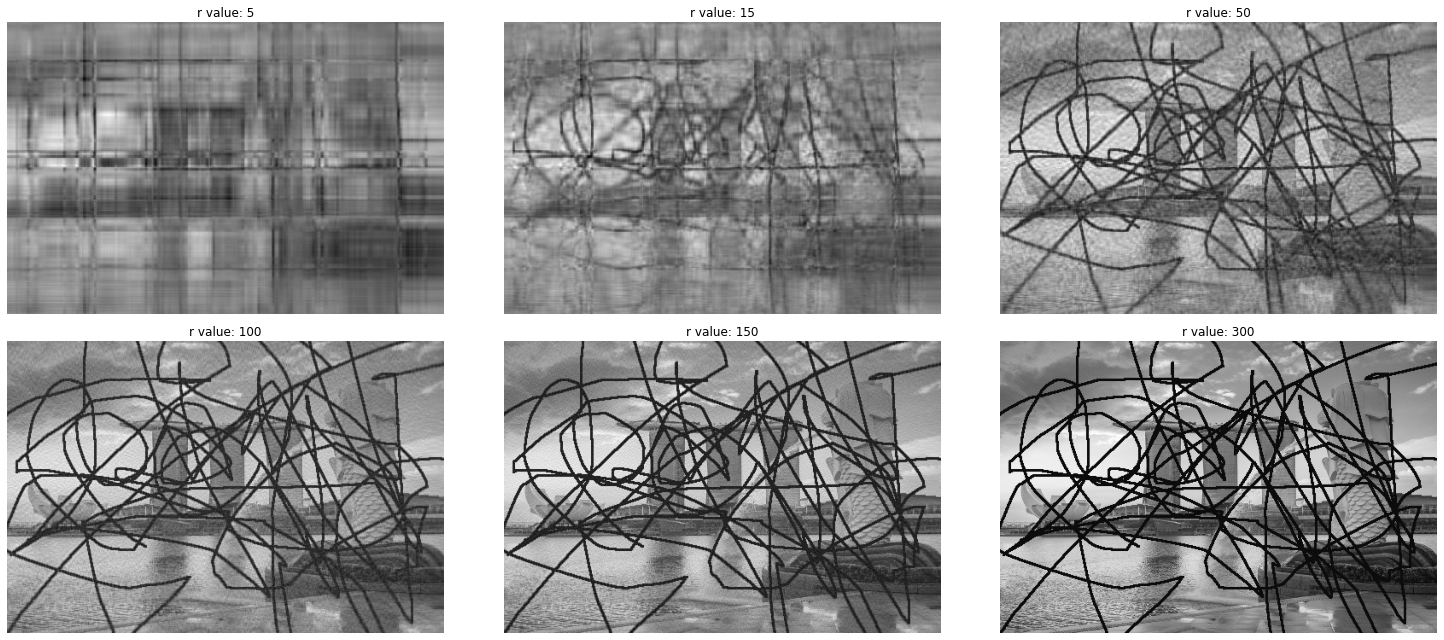

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(21,9))
count = 0
for row in range(2):
    for col in range(3):
        #print(row, col)
        ax[row][col].imshow(images[count], cmap='gray')
        ax[row][col].set_title(f"r value: {rank_values[count]}")
        ax[row][col].set_axis_off()
        count+=1
plt.tight_layout()
plt.show()

Recall that our optimization problem is:

\begin{align}
Z^* &= \underset{Z}{\mathrm{argmin}} 
    \sum_{\mathrm{Observed(i,j)}}
        (X_{i,j} - Z_{i,j})^2 
\end{align}

To minimize the loss we can merely replace the observed value by the actual value, however, this will lead to a loss of 0 and not achieve any reconstruction.

Hence, we need to add a regularization term to properly reconstruct the image. Thus our updated optimization problem is as follows:

\begin{align}
Z^* &= \underset{Z}{\mathrm{argmin}} 
    \sum_{\mathrm{Observed(i,j)}}
        (X_{i,j} - Z_{i,j})^2  + \lambda||Z||_2 \\
\end{align}

In [ ]:
r = 100
w,h = im.shape
print(w,h) # w = 342, h = 512

df = pd.DataFrame(im.copy())
df.replace(0, value=onp.nan, inplace=True)
missing_values = df.isna().values # mask of the missing values

U_init = onp.random.normal(0,1,size=(w,r)) / onp.sqrt(w*r)
V_init = onp.random.normal(0,1,size=(r,h)) / onp.sqrt(h*r)

342 512


We are approximating $X \in \mathbb{R}^{342,512}$ by two matrices $U \in \mathbb{R}^{p,r}$ and $V \in \mathbb{R}^{r,q}$:

\begin{align}
X &\approx Z = UV\\
p &= 342 \\
q &= 512 \\
r &= 100
\end{align}


## Loss and Minimisation functions

In [ ]:
regularization = 0
order = 2
@jax.jit
def loss(U, V, reg=0, norm=2):
    """ 
    calculates the loss 
    
    reg::float: lambda value for regularization
    norm::int or str: order of the norm to use for regularization
    
    """
    return jnp.sum( ((im-U@V)[~missing_values])**2 ) + reg*jnp.linalg.norm(U@V, ord=norm)

def loss_u_wrapper(U_flat):
    """
    takes in a flattened U array and returns the loss
    """
    U = U_flat.reshape(w, r)
    return loss(U, V, reg=regularization)

def loss_v_wrapper(V_flat, reg=regularization):
    """
    takes in a flattened V array and returns the loss
    """
    V = V_flat.reshape(r, h)
    return loss(U, V, reg=regularization)

grad_loss_u  = jax.jit( jax.grad(loss, argnums=0) ) # differentiate with respect to U: args[0]
grad_loss_v = jax.jit( jax.grad(loss, argnums=1) ) # differentiate with respect to V: args[1]


def grad_u_wrapper(U_flat):
    """
    takes in a flattened U array and return the gradient of the loss with respect to u

    Note: This is to be used when you fix V
    """
    U = U_flat.reshape(w,r)
    return onp.array(grad_loss_u(U,V)).ravel()


def grad_v_wrapper(V_flat, norm=order):
    """
    takes in a flattened V array and returns the gradient of the loss with respect to v

    Note: This is to be used when you fix U
    """
    V = V_flat.reshape(r,h)
    return onp.array(grad_loss_v(U,V)).ravel()


# we will minimize the function iteratively: alternative between holding U fixed, then V fixed

def minimize_U_fixed(U, V, reg=regularization, n_iter=100):
    """
    U is fixed, we minimize with respect to V
    
    L-BFGS Code is from Tutorial 6
    """
    traj = scipy.optimize.minimize(fun = loss_v_wrapper, #function to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                tol = 1e-8,
                                options={"maxiter":n_iter})  #maximum number of iteration
    
    V = traj["x"].reshape(r,h)
    return V

def minimize_V_fixed(U, V, reg=regularization, n_iter=100):
    """
    V is fixed, we minimize with respect to U
    
    L-BFGS Code is from Tutorial 6
    """
    traj = scipy.optimize.minimize(fun = loss_u_wrapper, #function to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_u_wrapper, #function that computes the gradient
                                tol = 1e-8,
                                options={"maxiter":n_iter})  #maximum number of iteration
    
    U = traj["x"].reshape(w,r)
    return U

In [ ]:
# instantize and compile function so subsequent runs are faster
U,V = onp.copy(U_init), onp.copy(V_init)
regularization = 0
loss(U,V,regularization)

CPU times: user 151 ms, sys: 17.1 ms, total: 168 ms
Wall time: 133 ms


## Model Training

Here we train and tune our model for different values of lambda and different types of norms to find the best performing combination. However, this approach of a gridsearch would require us to try a large number of combinations. To save time, we first tune for lambda, fix our lambda then tune for different types of norms. First, we tune our penalty term, and try out for different penalty values: $\lambda = {0.01, 0.1, 0.5, 1, 5, 10, 50, 100}$

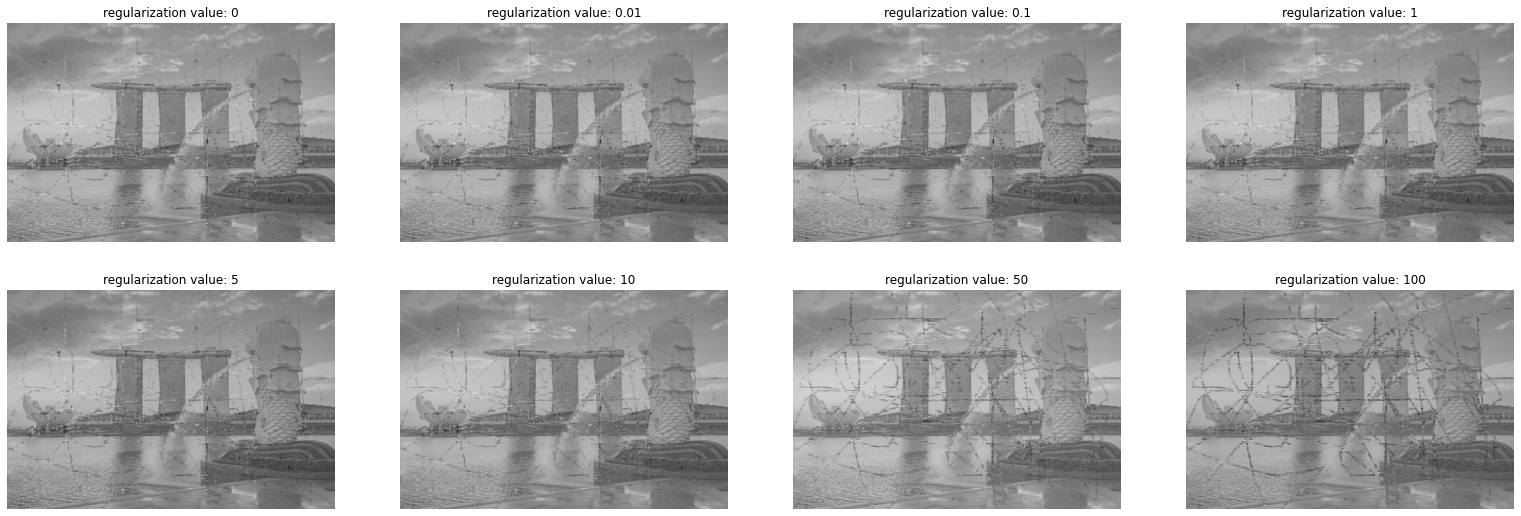

In [ ]:
d = {}
fig, ax = plt.subplots(2, 4, figsize=(27,9))
lambdas = [0, 0.01, 0.1, 1, 5, 10, 50, 100]
count = 0

for row in range(2):
    for col in range(4):
        #print(row, col)
        U,V = onp.copy(U_init), onp.copy(V_init)
        regularization = lambdas[count]
        loss_history=[]
        n = 5
        LBFGS_iter = 100

        for i in range(n):
            V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            loss_history.append(loss(U,V))

        d[regularization] = loss_history
        z = U @ V
        for i in range(w):
            for j in range(h):
                if ~missing_values[i,j]: # not missing value
                    z[i,j] = im[i,j]
        # plot resulting image
        ax[row][col].set_title(f"regularization value: {regularization}")
        ax[row][col].set_axis_off()
        ax[row][col].imshow(z,cmap="gray")
        count+= 1

In [ ]:
all_losses = pd.DataFrame(d)
all_losses

,0.00,0.01,0.10,1.00,5.00,10.00,50.00,100.00
0,598.7727421747052,597.2643369458584,598.3556812383301,597.8112294336147,599.1547659491947,611.3326963619608,1743.8582579155432,1626.6173264866927
1,107.37871828693646,106.69027583900137,106.02959308722681,106.04178115584125,110.14582793873623,118.86039982156356,441.93165045083487,715.060084560635
2,74.60800856068444,74.33210388574102,74.27019644896593,74.39203614707944,80.58198849206268,88.18975926216322,441.93165045083475,715.0600845606351
3,64.25925271571857,63.97552366944859,64.0527400144612,64.19013491666766,67.91684194024563,81.19307481998123,441.9316504508348,715.060084560635
4,59.0714752765105,58.811422531540444,58.980838033261556,59.071987842165086,63.848730157656995,79.81635989094295,441.9316504508346,715.0600845606351


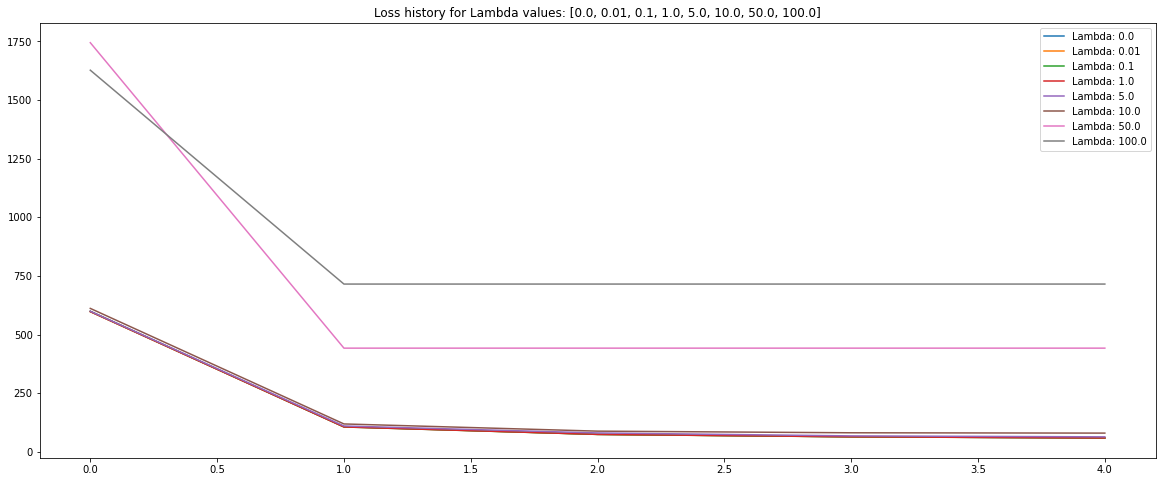

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes()
ax.set_title(f"Loss history for Lambda values: {list(all_losses.columns)}")
for lambda_value in list(all_losses.columns):
    #print(lambda_value)
    curr_loss_history = all_losses[[lambda_value]]
    curr_min_loss = onp.min(curr_loss_history.values)
    ax.plot(curr_loss_history, label=f"Lambda: {lambda_value}")
    #print(f"lambda value: {lambda_value}, loss:{curr_min_loss}")
plt.legend()
plt.show()

In [ ]:
for lambda_value in list(all_losses.columns):
    curr_loss_history = all_losses[[lambda_value]]
    curr_min_loss = onp.min(curr_loss_history.values)
    print(f"lambda value: {lambda_value}, loss:{curr_min_loss}")

lambda value: 0.0, loss:59.0714752765105
lambda value: 0.01, loss:58.811422531540444
lambda value: 0.1, loss:58.980838033261556
lambda value: 1.0, loss:59.071987842165086
lambda value: 5.0, loss:63.848730157656995
lambda value: 10.0, loss:79.81635989094295
lambda value: 50.0, loss:441.9316504508346
lambda value: 100.0, loss:715.060084560635


We can see that L-BFGS converges quickly after only one or two epochs. The minimum loss occurs at small levels of regularization with small lambda values, but the image quality is clearly seen to be not the best. It is difficult to use a metric as a measure of how good the image inpainting is. We can only visually inspect the reconstruction, where the best image quality appears to be at $\lambda = 1$. Thus, let us fix $\lambda =1$ and next tune which norm performs the best.



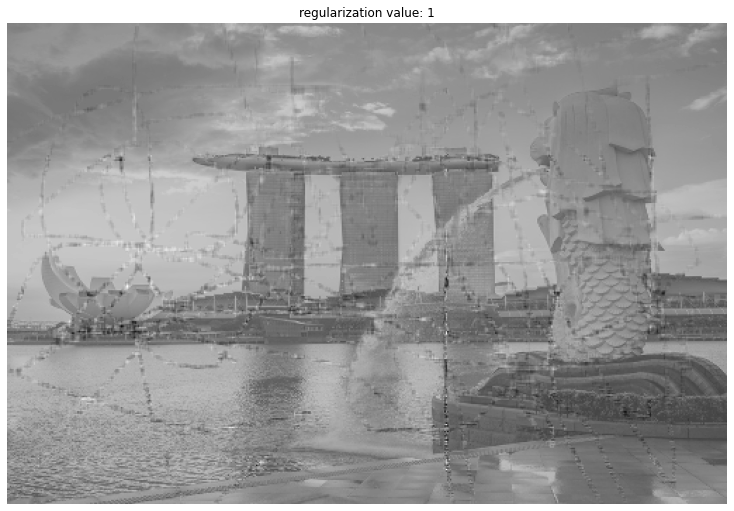

In [ ]:
U,V = onp.copy(U_init), onp.copy(V_init)
regularization = 1
loss_history=[]

for i in tqdm(range(n)):
    V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    #loss_history.append(loss(U,V))

# reconstruct the matrix
z = U @ V
for i in range(w):
    for j in range(h):
        if ~missing_values[i,j]: # not missing value
            z[i,j] = im[i,j]
# plot resulting image
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title(f"regularization value: {regularization}")
ax.set_axis_off()
ax.imshow(z,cmap="gray")
plt.show()

## Regularization Types
We know that L1, L2 and different types of norm affect the image reconstruction differently. We know that L2 leads to overly smooth images, but the other properties of different Norms are unknown. Hence, fixing $\lambda = 1$, we try out different norms $||Z||_* \in \{L1, L2, Frobenius, Nuclear\}$. 


\begin{align}
||Z||_{Frobenius} &= \sqrt{\sum_{i=1}^{342}\sum_{j=1}^{512} |Z_{i,j}|^2} \\
||Z||_{Nuclear} &= \sqrt{\sum_{i=1}^{342}\sum_{j=1}^{512} |Z_{i,j}|}
\end{align}


and our optimization problem is as below:


\begin{align}
Z^* &= \underset{Z}{\mathrm{argmin}} 
    \sum_{\mathrm{Observed(i,j)}}
        (X_{i,j} - Z_{i,j})^2  + \lambda||Z||_* \\
\end{align}

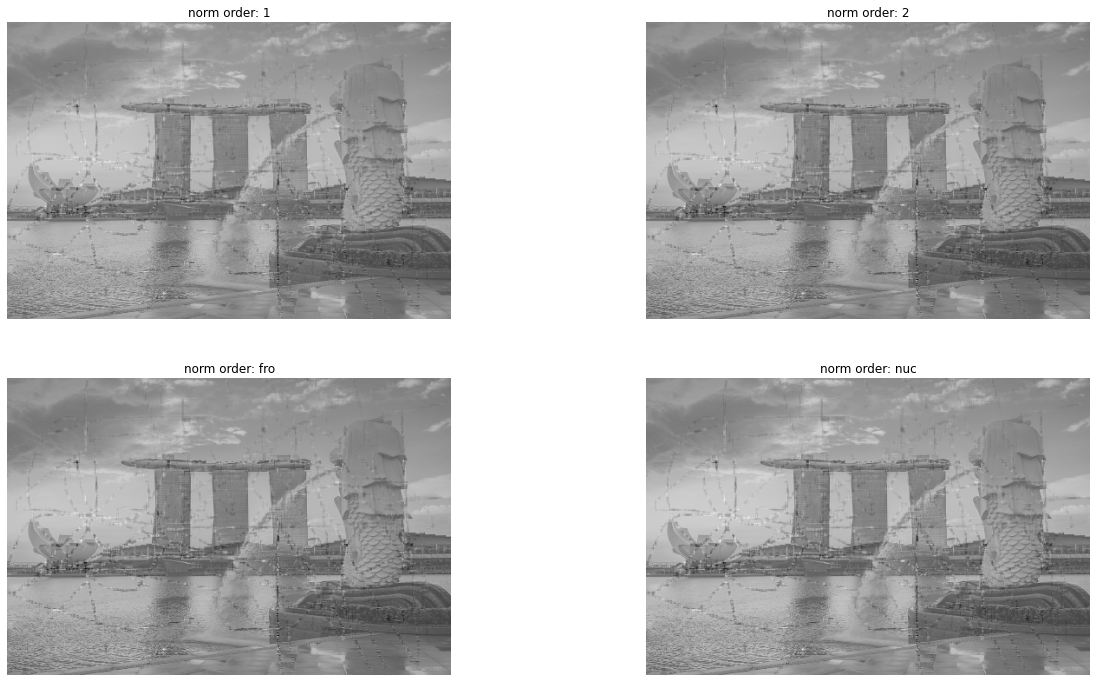

In [ ]:
norms = [1, 2, 'fro', 'nuc']
d = {}
fig, ax = plt.subplots(2, 2, figsize=(21,12))
count = 0

for row in range(2):
    for col in range(2):

        norm=norms[count]
        regularization = 1 # best regularization

        @jax.jit
        def loss(U, V, reg=regularization, norm=norm):
            """ calculates the loss """
            return jnp.sum( ((im-U@V)[~missing_values])**2 ) + reg*jnp.linalg.norm(U@V, ord=norm)
        
        #print(row, col)
        U,V = onp.copy(U_init), onp.copy(V_init)
        loss_history=[]
        n = 5
        LBFGS_iter = 100

        for i in range(n):
            V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            loss_history.append(loss(U,V))

        d[norm] = loss_history
        z = U @ V
        for i in range(w):
            for j in range(h):
                if ~missing_values[i,j]: # not missing value
                    z[i,j] = im[i,j]
        # plot resulting image
        ax[row][col].set_title(f"norm order: {norm}")
        ax[row][col].set_axis_off()
        ax[row][col].imshow(z,cmap="gray")
        count+= 1

We note that L2-Norm and Frobenius Norm gives the most natural results, as their inpainted lines looks normal, but Frobenius Norm contains more detail and does not contain the overly smooth reconstruction characteristic of a L2-Norm Reconstruction.

In [ ]:
all_losses = pd.DataFrame(d)
all_losses

,1,2,fro,nuc
0,841.0014257528117,832.8381200790278,841.1603050802936,1222.8154452520675
1,343.44023726202727,343.8932120968913,352.0402791337767,756.2269240504795
2,312.45833534530095,313.3405824588265,321.37427549371927,729.7949915377234
3,302.3788394379737,303.7285252880707,312.1008722788389,724.6226906208435
4,297.1272316315693,298.84559180057454,307.59155622253695,722.9039871754567


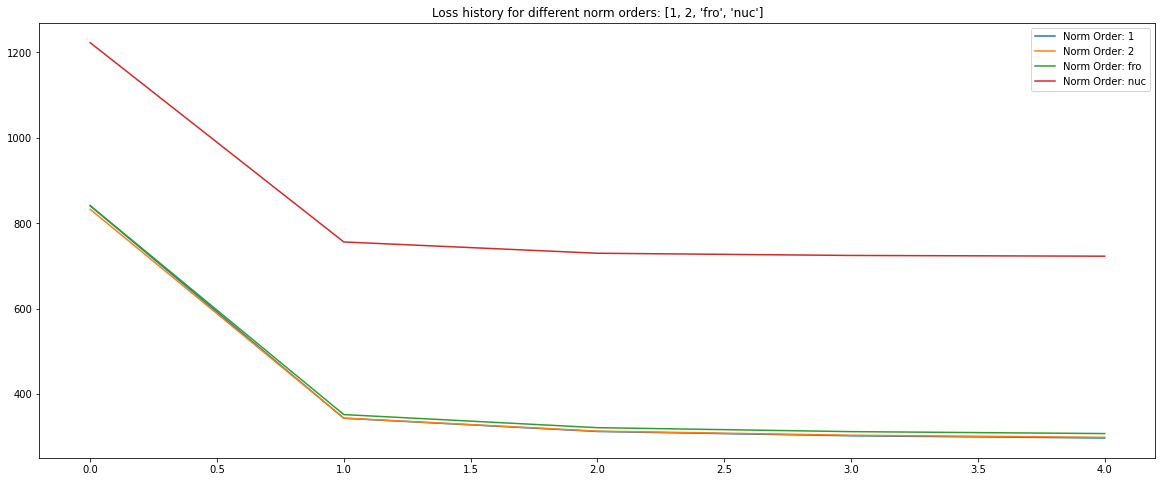

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes()
ax.set_title(f"Loss history for different norm orders: {list(all_losses.columns)}")
for norm_order in list(all_losses.columns):
    #print(norm_order)
    curr_loss_history = all_losses[[norm_order]]
    curr_min_loss = onp.min(curr_loss_history.values)
    ax.plot(curr_loss_history, label=f"Norm Order: {norm_order}")
    #print(f"lambda value: {norm_order}, loss:{curr_min_loss}")
plt.legend()
plt.show()

## Final Image

Our final reconstructed image uses the Frobenius Norm, as well as $\lambda=1$.

In [ ]:
norm = 'fro' # best regularization norm
regularization = 1 # best regularization

@jax.jit
def loss(U, V, reg=regularization, norm=norm):
    """ calculates the loss """
    return jnp.sum( ((im-U@V)[~missing_values])**2 ) + reg*jnp.linalg.norm(U@V, ord=norm)

U,V = onp.copy(U_init), onp.copy(V_init)
n = 5
LBFGS_iter = 100

for i in range(n):
    V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)

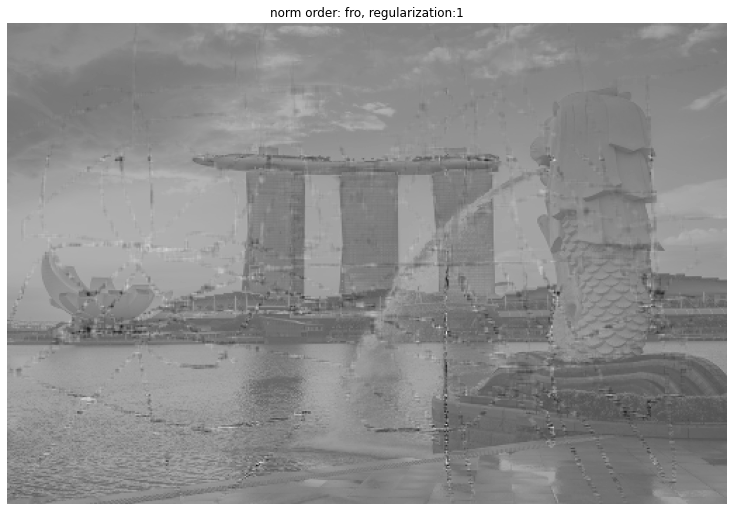

In [ ]:
z = U @ V
for i in range(w):
    for j in range(h):
        if ~missing_values[i,j]: # not missing value
            z[i,j] = im[i,j]

# plot resulting image
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title(f"norm order: {norm}, regularization:{regularization}")
ax.set_axis_off()
ax.imshow(z,cmap="gray")
plt.show()